# Mismatch Modifiers
Learn to use mismatch modifiers with this notebook!
Feel free to add other models, be sure to update the index and give you credit ;)

Table of contents:
1. [Setup](#setup)
1. [N. Martin & J. M. Ruiz Experimental Mismatch Modifier](#n-martin--j-m-ruiz-experimental-mismatch-modifier)

Authors:
* Echedey Luis (@echedey-ls), 2023 Feb

## Setup
Let's prepare the environment:

In [9]:
# Show matplotlib's figures in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

# And pvlib
import pvlib

### N. Martin & J. M. Ruiz Mismatch Modifier
This modifier takes into account the responsivities to different spectrums,
characterized by the airmass and the clearness index, as two independent
variables. In fact, it is 3 different modifiers, each one for each component
(``poa_direct``, ``poa_sky_diffuse``, ``poa_ground_diffuse``)

The formula for each component has three coefficients; we are lucky the authors
of this model computed fitting values for m-Si, p-Si and a-Si!
However, if you would like to compute and/or use your own values, keep reading.
[TODO: LO HAGO O NO LO HAGO?? ###]

First step is get to the effective irradiance. For simplicity, we will copy the procedure explained in the tutorial ``tmy_to_power.ipynb``. Please refer to it to get a more in depth explanation.

In [10]:
site = pvlib.location.Location(40.4534, -3.7270, altitude=664,
                               name='IES-UPM, Madrid', tz='CET')

surface_tilt = 40
surface_azimuth = 180  # Pointing South

tmy_data, _, _, _ = pvlib.iotools.get_pvgis_tmy(site.latitude, site.longitude, map_variables=True,
                                                startyear=2005, endyear=2015)
tmy_data.index = [ts.replace(year=2022) for ts in tmy_data.index]

solar_pos = site.get_solarposition(tmy_data.index)

extra_rad = pvlib.irradiance.get_extra_radiation(tmy_data.index)

poa_sky_diffuse = \
    pvlib.irradiance.haydavies(surface_tilt, surface_azimuth, tmy_data['dhi'],
                               tmy_data['dni'], extra_rad,
                               solar_pos['apparent_zenith'], solar_pos['azimuth'])

poa_ground_diffuse = pvlib.irradiance.get_ground_diffuse(surface_tilt, tmy_data['ghi'])

aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth,
                           solar_pos['apparent_zenith'], solar_pos['azimuth'])

# Let's consider this the irradiances without modifiers
# We can calculate the mismatch before and then create a "poa_irrad" var for
# modified irradiances, but we are also doing this to compare later.
# 'spectrum.martin_ruiz_spectral_modifier' result is designed to make it
# easy to multiply each modifier and the irradiance component with a single
# line of code.
poa_irrad = pvlib.irradiance.poa_components(aoi, tmy_data['dni'], poa_sky_diffuse, poa_ground_diffuse)

# Following part will be needed later
thermal_params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
pvtemps = pvlib.temperature.sapm_cell(poa_irrad['poa_global'],
                                      tmy_data['temp_air'],
                                      tmy_data['wind_speed'],
                                      **thermal_params)

# Note that we use the CEC Module provided for the singlediode subsection
cec_modules = pvlib.pvsystem.retrieve_sam(name='CECMod')
cec_module = cec_modules['Canadian_Solar_Inc__CS5P_220M']

Here comes the modifier. Let's calculate it and examine the introduced
difference.


That was a lot, yeah. But don't worry, now we can find the effective irradiance, the mismatch modifier (with the airmass and clearness index)

In [11]:
# First, let's find the airmass and the clearness index
# Little caution: default values for this model were fitted obtaining the airmass through the kasten1966 method, not used by default
airmass = site.get_airmass(solar_position=solar_pos, model='kasten1966')
clearness = pvlib.irradiance.clearness_index(ghi=tmy_data['ghi'],
                                             solar_zenith=solar_pos['zenith'],
                                             extra_radiation=extra_rad)
# Check module is m-Si (monocrystalline silicon)
print('Module type is: ' + cec_module['Technology'])

# Get the mismatch modifiers
modifiers = pvlib.spectrum.martin_ruiz_spectral_modifier(clearness,
                                                         airmass['airmass_absolute'],
                                                         cell_type='monosi')

Module type is: Mono-c-Si


And then we can find the 3 components modified irradiances by means of a simple
multiplication.

Note, however, that neither this does modify ``poa_global`` nor
``poa_diffuse``, so we should update.

In [12]:
poa_irrad_modified = poa_irrad * modifiers
# We need global modified irradiance for the output power calculation
poa_irrad_modified = \
    pvlib.irradiance.poa_components(aoi,
                                    poa_irrad_modified['poa_direct'],
                                    poa_irrad_modified['poa_sky_diffuse'],
                                    poa_irrad_modified['poa_ground_diffuse'])

Let's plot the raw vs modified global irradiances, and the difference.

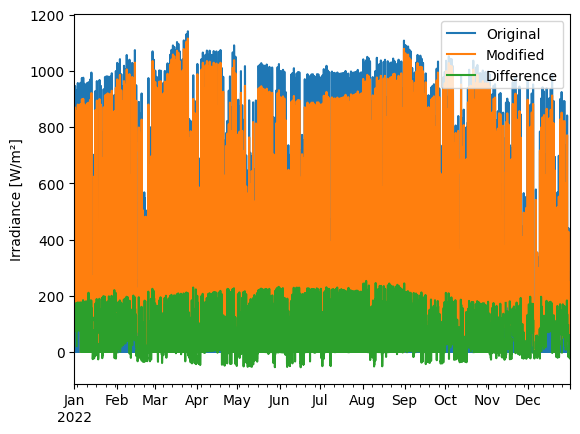

In [13]:
poa_irrad_global_diff = (poa_irrad['poa_global']
                         - poa_irrad_modified['poa_global'])
poa_irrad['poa_global'].plot()
poa_irrad_modified['poa_global'].plot()
poa_irrad_global_diff.plot()
plt.legend(['Original', 'Modified', 'Difference'])
plt.ylabel('Irradiance [W/m²]')
plt.show()

Finally, we can get the power result. Instead of using
``pvlib.pvsystem.sapm_effective_irradiance``, which already applies another
experimental model for the response of the solar module, we have to use the
diode model.

Have a look to subsection ``DC power using single diode`` in notebook
``tmy_to_power.ipynb``. This is just the same two times.

In [14]:
module_params = {k: cec_module[k]
                 for k in ['a_ref', 'I_L_ref', 'I_o_ref', 'R_sh_ref', 'R_s', 'alpha_sc']}

Again, we compute one considering the modifier and another one without it.

In [15]:
# With modifier
photocurrent, saturation_current, resistance_series, resistance_shunt, nNsVth = \
    pvlib.pvsystem.calcparams_desoto(poa_irrad_modified['poa_global'],
                                     pvtemps,
                                     EgRef=1.121,
                                     dEgdT=-0.0002677,
                                     **module_params)
single_diode_out_modified = pvlib.pvsystem.singlediode(photocurrent, saturation_current,
                                                       resistance_series, resistance_shunt,
                                                       nNsVth)
# Without modifier
photocurrent, saturation_current, resistance_series, resistance_shunt, nNsVth = \
    pvlib.pvsystem.calcparams_desoto(poa_irrad['poa_global'],
                                     pvtemps,
                                     EgRef=1.121,
                                     dEgdT=-0.0002677,
                                     **module_params)
single_diode_out = pvlib.pvsystem.singlediode(photocurrent, saturation_current,
                                              resistance_series, resistance_shunt,
                                              nNsVth)

C:\Users\Yo\Documents\01_UPM\IES\ISI-IES-GROUP-codes\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))
C:\Users\Yo\Documents\01_UPM\IES\ISI-IES-GROUP-codes\pvlib-python\pvlib\tools.py:359: RuntimeWarning: divide by zero encountered in divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


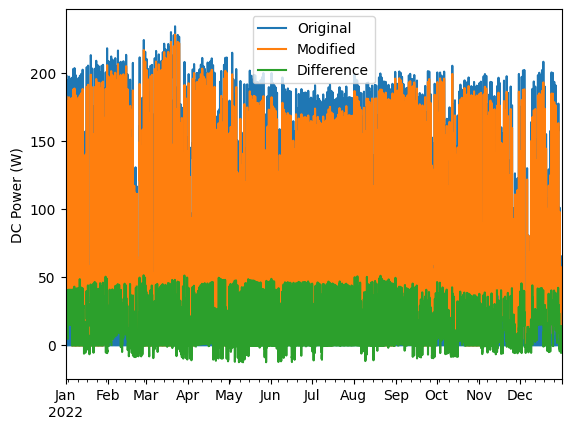

In [16]:
# Calculate difference of max power output
single_diode_out_max_pwr_diff = (single_diode_out['p_mp']
                                 - single_diode_out_modified['p_mp'])
# Plot results
single_diode_out['p_mp'].plot()
single_diode_out_modified['p_mp'].plot()
single_diode_out_max_pwr_diff.plot()
plt.legend(['Original', 'Modified', 'Difference'])
plt.ylabel('DC Power (W)')
plt.show()